## Delivery time prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn import neighbors
from sklearn.svm import SVR
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error


def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute distance between two pairs of (lat, lng)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

In [8]:
from google.colab import files
uploaded = files.upload()

Saving 05.order_items.csv to 05.order_items.csv


In [9]:
# Read tables
geolocation = pd.read_csv('01.geo.csv',
                     sep=';',
                     error_bad_lines=False,
                     engine='python',
                     encoding='unicode_escape')

customers = pd.read_csv('02.customers.csv',
                        sep=';',
                        error_bad_lines=False,
                        engine='python',
                        encoding='unicode_escape')

sellers = pd.read_csv('03.sellers.csv',
                         sep=';',
                         error_bad_lines=False,
                         engine='python',
                         encoding='unicode_escape')

orders = pd.read_csv('04.order_status.csv',
                            sep=';',
                            error_bad_lines=False,
                            engine='python')

order_items= pd.read_csv('05.order_items.csv',
                           sep=';',
                           error_bad_lines=False,
                           engine='python')

products = pd.read_csv('08.products.csv',
                          sep=';',
                          error_bad_lines=False,
                          engine='python')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
geolocation

,geo_city,geo_latitude,geo_longitude,geo_admin1_code,geo_autonomous_community
0,Ibiza - Ibiza,38.90883,1.43296,7,Baleares
1,Calviá - Mallorca,39.56570,2.50621,7,Baleares
2,Pontevedra,42.43100,-8.64435,58,Galicia
3,Gerona,41.98311,2.82493,56,Cataluña
4,Toledo,39.85810,-4.02263,54,Castilla-La Mancha
...,...,...,...,...,...
63,Alcalá de Henares,40.48205,-3.35996,29,Comunidad de Madrid
64,Badajoz,38.87789,-6.97061,57,Extremadura
65,Gijón,43.53573,-5.66152,34,Principado de Asturias
66,Ourense,42.33669,-7.86407,58,Galicia


In [11]:
np.deg2rad(geolocation.geo_latitude)

0     0.679087
1     0.690552
2     0.740561
3     0.732743
4     0.695655
        ...   
63    0.706545
64    0.678547
65    0.759842
66    0.738915
67    0.743511
Name: geo_latitude, Length: 68, dtype: float64

Dropped rows with no delivery date, a few others also which didn't have approval date.

In [12]:
orders = orders[orders['order_status'] == 'delivered']

In [13]:
order_items = pd.merge(order_items, sellers[['seller_id','seller_city']], left_on='seller_id', right_on='seller_id').drop(['order_item_sequence_id','max_shipping_seller_date'], axis=1)
order_items

,order_id,product_id,price,shipping_cost,seller_id,seller_city
0,e5fa5a7210941f7d56d0208e4e071d35,f3c2d01a84c947b078e32bbef0718962,"59,5","15,56",a425f92c199eb576938df686728acd20,Coruña
1,c38c0f119b3e3e8985c68a0204872116,acc10c61bc17a1c18cae33d4884f7e79,34,"12,48",a425f92c199eb576938df686728acd20,Coruña
2,dbe73e59815a2106ffcba61fa14592e9,2eefd8ed7a9782380fe14a1efdec7418,39,"15,79",a425f92c199eb576938df686728acd20,Coruña
3,77fff204e0af2e1abdaea52727cf9d15,2cb90322408fbc8131f039ac650b87f9,"41,5","15,79",a425f92c199eb576938df686728acd20,Coruña
4,448645ea240ea7aa0dcc61d2cad9eb5d,852f63621d87c7e78bfc4246a251e11f,27,"7,89",a425f92c199eb576938df686728acd20,Coruña
...,...,...,...,...,...,...
112650,d85ce87a3af93d77d9ffb99a90c76710,184908160c13d25f992d86d43cba2e90,"25,5","7,44",e0487761face83d64fcada2408959a36,Madrid
112651,fa0c6595d02f168f7557693dbffa7b69,896496916bfd78848143a60e492dbcf8,"23,75","7,43",e0487761face83d64fcada2408959a36,Madrid
112652,b2bee079651c0bf6a1a92b39c2dbe5cf,c1c4271977e10331523b010496ab2f9b,299,"19,3",b76f4d90e85657a240495c876313adc5,Almería
112653,d9fba4d4669d79e886681d5bfbdf9f17,f3231cefd20f5eeb7a400d49b3c8163e,"139,49","15,29",26e2e5033827d2ba53929f43e03d8ffe,Madrid


Merging all datasets together

In [14]:
merge_df = pd.merge(order_items, orders, left_on='order_id', right_on='order_id', how='left')
merge_df = pd.merge(merge_df, customers[['customer_id', 'customer_city']], how='left',left_on='customer_id',right_on='customer_id')
geo = geolocation.groupby('geo_city').mean().reset_index()


In [15]:
merge_df = pd.merge(merge_df, geo[['geo_city', 'geo_latitude', 'geo_longitude']], how='left', 
                    left_on='seller_city', right_on='geo_city').rename(columns={'geolocation_lat': 'seller_lat', 
                                                                                                              'geolocation_lng': 'seller_lon'})
merge_df = pd.merge(merge_df, geo[['geo_city', 'geo_latitude', 'geo_longitude']], how='inner', 
                    left_on='customer_city', right_on='geo_city').rename(columns={'geolocation_lat': 'customer_lat', 
                                                                                                              'geolocation_lng': 'customer_lon'})

In [16]:
merge_df = pd.merge(merge_df, products[['product_id','product_category_name','product_photo_quantity','product_weight_gr','product_length_cm','product_height_cm','product_width_cm']], 
                   left_on='product_id', right_on='product_id', how='left')

Extracting the month, day of week of a purchase. Also extract the actual delivery time, estimated delivery time and delivery time to carrier in days.

In [17]:

merge_df.ts_order_delivered_customer = pd.to_datetime(merge_df.ts_order_delivered_customer)
merge_df.ts_order_delivered_carrier = pd.to_datetime(merge_df.ts_order_delivered_carrier)
merge_df.ts_order_purchase = pd.to_datetime(merge_df.ts_order_purchase)
merge_df.ts_order_estimated_delivery = pd.to_datetime(merge_df.ts_order_estimated_delivery)
merge_df['purchase_month']=merge_df.ts_order_purchase.dt.month
merge_df['purchase_day_of_week']=merge_df.ts_order_purchase.dt.day_of_week
merge_df['actual_delivery_time']=(merge_df.ts_order_delivered_customer-merge_df.ts_order_purchase).dt.days
merge_df['carrier_delivery_time']=(merge_df.ts_order_delivered_carrier-merge_df.ts_order_purchase).dt.days
merge_df['estimated_delivery_time']=(merge_df.ts_order_estimated_delivery-merge_df.ts_order_purchase).dt.days

merge_df['distance'] = merge_df.apply(
    lambda row: haversine_distance(
        row['geo_latitude_y'],
        row['geo_longitude_y'],
        row['geo_latitude_x'],
        row['geo_longitude_x'],
    ),
    axis=1,
)

In [18]:
merge_df

,order_id,product_id,price,shipping_cost,seller_id,seller_city,customer_id,order_status,ts_order_purchase,ts_order_approved,...,product_weight_gr,product_length_cm,product_height_cm,product_width_cm,purchase_month,purchase_day_of_week,actual_delivery_time,carrier_delivery_time,estimated_delivery_time,distance
0,c38c0f119b3e3e8985c68a0204872116,acc10c61bc17a1c18cae33d4884f7e79,34,"12,48",a425f92c199eb576938df686728acd20,Coruña,4a7a0d968dbe3fe412df2fc1c107dd1d,delivered,2018-03-10 18:52:00,03/10/2018 19:07,...,400.0,18.0,18.0,18.0,3,5,222.0,216.0,234,106.500804
1,f7a7ff7ed71be9695fcaa57975abe814,64361cf847b7ebbd89d37266c947356c,"67,9","18,05",b335c59ab742f751a85db9c411a86739,Parla,16d9b76f2e917b32da9489cf45521d34,delivered,2018-07-22 20:31:00,22/07/2018 20:45,...,1900.0,26.0,26.0,25.0,7,6,77.0,8.0,31,474.613628
2,b57410d258461ade68673ab75276e66d,4981f1410716b81db3808ba1c7d21394,"19,9","14,52",e8f6dc8e6a1dcde89d20e3995c8d90b3,Madrid,bb248ad930ce8aa8dc295b01218e383f,delivered,2018-02-26 19:31:00,26/02/2018 19:45,...,200.0,20.0,2.0,16.0,2,0,14.0,4.0,23,468.878354
3,f2a5336cc1662ad56b16f4ed6e4b2de5,4a90b44b456e79e7a33435fdd36e551f,380,"49,7",c9a06ece156bb057372c68718ec8909b,Murcia,b0b27c44f7e3d2c6e45d506cbd4a5627,delivered,2018-01-15 17:55:00,15/01/2018 18:05,...,10700.0,32.0,63.0,32.0,1,0,9.0,0.0,18,806.520643
4,fcd0f8a6842216f0d6d5a217883eb711,fb29f48bfea41db52e349454f433340e,22,"15,1",897060da8b9a21f655304d50fd935913,Granada,d69a8c77693b6b01a1305ba425a1527d,delivered,2018-06-14 14:01:00,17/06/2018 03:15,...,300.0,39.0,9.0,20.0,6,3,15.0,8.0,22,724.276240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109346,9b189f6cf2ef734a7dd0419ed3c64d99,9c60e93e03989cf6e4a7da214723920d,169,"31,45",58f1a6197ed863543e0136bdedb3fce2,Móstoles,f8508e9ec506a046a25f3a4a63d0c630,delivered,2019-11-05 10:49:00,11/05/2019 11:09,...,3675.0,37.0,30.0,18.0,11,1,-133.0,-175.0,-146,549.494102
109347,991703c45ec0cba840f6623e6912b2ce,484bf1dff778a416389aafd0dee1cb11,60,"51,14",9803a40e82e45418ab7fb84091af5231,Zaragoza,e2118da5dede84095fa3d95920c68836,delivered,2019-06-30 09:36:00,30/06/2019 10:15,...,350.0,21.0,9.0,16.0,6,6,31.0,-143.0,-115,368.191664
109348,c3b1312808b5e55eda5efa7fcb111b00,27af179c53bb244ebe3a62f66549beb3,"92,9","77,42",70125af26c2d6d4ef401a1d02ae7701f,Zaragoza,1e889a782d674324faeacb81ad066144,delivered,2019-03-07 16:23:00,05/07/2019 16:34,...,3900.0,80.0,21.0,17.0,3,3,138.0,91.0,-28,368.191664
109349,c3b1312808b5e55eda5efa7fcb111b00,27af179c53bb244ebe3a62f66549beb3,"92,9","77,42",70125af26c2d6d4ef401a1d02ae7701f,Zaragoza,1e889a782d674324faeacb81ad066144,delivered,2019-03-07 16:23:00,05/07/2019 16:34,...,3900.0,80.0,21.0,17.0,3,3,138.0,91.0,-28,368.191664


In [19]:
merge_df['product_volume_cm3']=merge_df.product_length_cm * merge_df.product_height_cm * merge_df.product_width_cm

In [20]:

merge_df['price']= merge_df['price'].str.replace(',', '.').astype(float)

In [21]:

merge_df['shipping_cost']= merge_df['shipping_cost'].str.replace(',', '.').astype(float)

Viewing some statistics on the order features. As it can be seen there are order with more than 200 days delay which are outliers or incorrect data.

In [22]:
merge_df = merge_df.dropna()
merge_df

,order_id,product_id,price,shipping_cost,seller_id,seller_city,customer_id,order_status,ts_order_purchase,ts_order_approved,...,product_length_cm,product_height_cm,product_width_cm,purchase_month,purchase_day_of_week,actual_delivery_time,carrier_delivery_time,estimated_delivery_time,distance,product_volume_cm3
0,c38c0f119b3e3e8985c68a0204872116,acc10c61bc17a1c18cae33d4884f7e79,34.0,12.48,a425f92c199eb576938df686728acd20,Coruña,4a7a0d968dbe3fe412df2fc1c107dd1d,delivered,2018-03-10 18:52:00,03/10/2018 19:07,...,18.0,18.0,18.0,3,5,222.0,216.0,234,106.500804,5832.0
1,f7a7ff7ed71be9695fcaa57975abe814,64361cf847b7ebbd89d37266c947356c,67.9,18.05,b335c59ab742f751a85db9c411a86739,Parla,16d9b76f2e917b32da9489cf45521d34,delivered,2018-07-22 20:31:00,22/07/2018 20:45,...,26.0,26.0,25.0,7,6,77.0,8.0,31,474.613628,16900.0
2,b57410d258461ade68673ab75276e66d,4981f1410716b81db3808ba1c7d21394,19.9,14.52,e8f6dc8e6a1dcde89d20e3995c8d90b3,Madrid,bb248ad930ce8aa8dc295b01218e383f,delivered,2018-02-26 19:31:00,26/02/2018 19:45,...,20.0,2.0,16.0,2,0,14.0,4.0,23,468.878354,640.0
3,f2a5336cc1662ad56b16f4ed6e4b2de5,4a90b44b456e79e7a33435fdd36e551f,380.0,49.70,c9a06ece156bb057372c68718ec8909b,Murcia,b0b27c44f7e3d2c6e45d506cbd4a5627,delivered,2018-01-15 17:55:00,15/01/2018 18:05,...,32.0,63.0,32.0,1,0,9.0,0.0,18,806.520643,64512.0
4,fcd0f8a6842216f0d6d5a217883eb711,fb29f48bfea41db52e349454f433340e,22.0,15.10,897060da8b9a21f655304d50fd935913,Granada,d69a8c77693b6b01a1305ba425a1527d,delivered,2018-06-14 14:01:00,17/06/2018 03:15,...,39.0,9.0,20.0,6,3,15.0,8.0,22,724.276240,7020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109346,9b189f6cf2ef734a7dd0419ed3c64d99,9c60e93e03989cf6e4a7da214723920d,169.0,31.45,58f1a6197ed863543e0136bdedb3fce2,Móstoles,f8508e9ec506a046a25f3a4a63d0c630,delivered,2019-11-05 10:49:00,11/05/2019 11:09,...,37.0,30.0,18.0,11,1,-133.0,-175.0,-146,549.494102,19980.0
109347,991703c45ec0cba840f6623e6912b2ce,484bf1dff778a416389aafd0dee1cb11,60.0,51.14,9803a40e82e45418ab7fb84091af5231,Zaragoza,e2118da5dede84095fa3d95920c68836,delivered,2019-06-30 09:36:00,30/06/2019 10:15,...,21.0,9.0,16.0,6,6,31.0,-143.0,-115,368.191664,3024.0
109348,c3b1312808b5e55eda5efa7fcb111b00,27af179c53bb244ebe3a62f66549beb3,92.9,77.42,70125af26c2d6d4ef401a1d02ae7701f,Zaragoza,1e889a782d674324faeacb81ad066144,delivered,2019-03-07 16:23:00,05/07/2019 16:34,...,80.0,21.0,17.0,3,3,138.0,91.0,-28,368.191664,28560.0
109349,c3b1312808b5e55eda5efa7fcb111b00,27af179c53bb244ebe3a62f66549beb3,92.9,77.42,70125af26c2d6d4ef401a1d02ae7701f,Zaragoza,1e889a782d674324faeacb81ad066144,delivered,2019-03-07 16:23:00,05/07/2019 16:34,...,80.0,21.0,17.0,3,3,138.0,91.0,-28,368.191664,28560.0


Drop rows that could contain possible outliers (Estimated delivery time>= 60 days). (Estimated delivery time>= -10 days) (Actual delivery time < 0). It's not possible to have negative actual delivery values. Maybe there's a problem in the company delivery system.

In [23]:
merge_df= merge_df[merge_df['estimated_delivery_time'] <= 60]
merge_df= merge_df[merge_df['estimated_delivery_time'] >= -60]
merge_df= merge_df[merge_df['actual_delivery_time']> 0]

In [24]:
merge_df

,order_id,product_id,price,shipping_cost,seller_id,seller_city,customer_id,order_status,ts_order_purchase,ts_order_approved,...,product_length_cm,product_height_cm,product_width_cm,purchase_month,purchase_day_of_week,actual_delivery_time,carrier_delivery_time,estimated_delivery_time,distance,product_volume_cm3
1,f7a7ff7ed71be9695fcaa57975abe814,64361cf847b7ebbd89d37266c947356c,67.90,18.05,b335c59ab742f751a85db9c411a86739,Parla,16d9b76f2e917b32da9489cf45521d34,delivered,2018-07-22 20:31:00,22/07/2018 20:45,...,26.0,26.0,25.0,7,6,77.0,8.0,31,474.613628,16900.0
2,b57410d258461ade68673ab75276e66d,4981f1410716b81db3808ba1c7d21394,19.90,14.52,e8f6dc8e6a1dcde89d20e3995c8d90b3,Madrid,bb248ad930ce8aa8dc295b01218e383f,delivered,2018-02-26 19:31:00,26/02/2018 19:45,...,20.0,2.0,16.0,2,0,14.0,4.0,23,468.878354,640.0
3,f2a5336cc1662ad56b16f4ed6e4b2de5,4a90b44b456e79e7a33435fdd36e551f,380.00,49.70,c9a06ece156bb057372c68718ec8909b,Murcia,b0b27c44f7e3d2c6e45d506cbd4a5627,delivered,2018-01-15 17:55:00,15/01/2018 18:05,...,32.0,63.0,32.0,1,0,9.0,0.0,18,806.520643,64512.0
4,fcd0f8a6842216f0d6d5a217883eb711,fb29f48bfea41db52e349454f433340e,22.00,15.10,897060da8b9a21f655304d50fd935913,Granada,d69a8c77693b6b01a1305ba425a1527d,delivered,2018-06-14 14:01:00,17/06/2018 03:15,...,39.0,9.0,20.0,6,3,15.0,8.0,22,724.276240,7020.0
5,fcd0f8a6842216f0d6d5a217883eb711,fb29f48bfea41db52e349454f433340e,22.00,15.10,897060da8b9a21f655304d50fd935913,Granada,d69a8c77693b6b01a1305ba425a1527d,delivered,2018-06-14 14:01:00,17/06/2018 03:15,...,39.0,9.0,20.0,6,3,15.0,8.0,22,724.276240,7020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109344,ce9f7444804995c448736c30b7072add,5650f9e1f73d0a1c0176988cf2e950d5,74.99,37.21,2d518637f53161b973e01f56ea4bb88e,Madrid,6c53bdf21834cdc653478cb386a92f0e,delivered,2019-04-25 07:38:00,25/04/2019 07:51,...,16.0,11.0,12.0,4,3,21.0,5.0,29,537.207227,2112.0
109345,0668d086b3ae41adde3aed3dacbc8fae,3d2083882f7be28ab6c8d9c807e3026c,209.00,43.74,02f623a8eb246f3c5f7c2f96462654e6,Cádiz,18e56af97c2f24afcfaf7aa97ad2b969,delivered,2019-03-07 17:39:00,05/07/2019 16:25,...,57.0,16.0,21.0,3,3,141.0,30.0,-59,840.556256,19152.0
109348,c3b1312808b5e55eda5efa7fcb111b00,27af179c53bb244ebe3a62f66549beb3,92.90,77.42,70125af26c2d6d4ef401a1d02ae7701f,Zaragoza,1e889a782d674324faeacb81ad066144,delivered,2019-03-07 16:23:00,05/07/2019 16:34,...,80.0,21.0,17.0,3,3,138.0,91.0,-28,368.191664,28560.0
109349,c3b1312808b5e55eda5efa7fcb111b00,27af179c53bb244ebe3a62f66549beb3,92.90,77.42,70125af26c2d6d4ef401a1d02ae7701f,Zaragoza,1e889a782d674324faeacb81ad066144,delivered,2019-03-07 16:23:00,05/07/2019 16:34,...,80.0,21.0,17.0,3,3,138.0,91.0,-28,368.191664,28560.0


Using a set of various models to estimate the delivery delay amount. We can also use an ensemble of the best models.

In [25]:


target = 'estimated_delivery_time'
features = ['product_weight_gr', 
            'purchase_day_of_week', 
            'price',
            'carrier_delivery_time',
            'distance','product_length_cm',	'product_height_cm','product_width_cm', 'purchase_month','shipping_cost','actual_delivery_time','product_volume_cm3']
X = merge_df[features]
y = merge_df[target]

X_data = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_data, y, train_size= 0.8,test_size=0.2, random_state = 14)


models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()] ,
           ['XGBoost: ', XGBRegressor()] ,
           #['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=10000,learning_rate_init=0.01,alpha=0.01)]
         ]

model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 100
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = metrics.r2_score(y_train,curr_model.predict(X_train))
    curr_model_data["Test_R2_Score"] = metrics.r2_score(y_test,curr_model.predict(X_test))
    curr_model_data["Test_RMSE"] = sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))/100
    model_data.append(curr_model_data)

[10:08:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
model_scores = pd.DataFrame(model_data)
model_scores

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE
0,Lasso:,0.014303,0.024243,0.023005,0.206418
1,Ridge:,0.028363,0.033013,0.029459,0.205735
2,KNeighborsRegressor:,0.132545,0.420363,0.093161,0.198869
3,RandomForest,29.791428,0.918517,0.411082,0.160262
4,ExtraTreeRegressor :,11.020750,1.000000,0.442531,0.155924
5,GradientBoostingRegressor:,6.748793,0.233483,0.214289,0.185112
6,XGBoost:,1.902817,0.232250,0.214748,0.185058


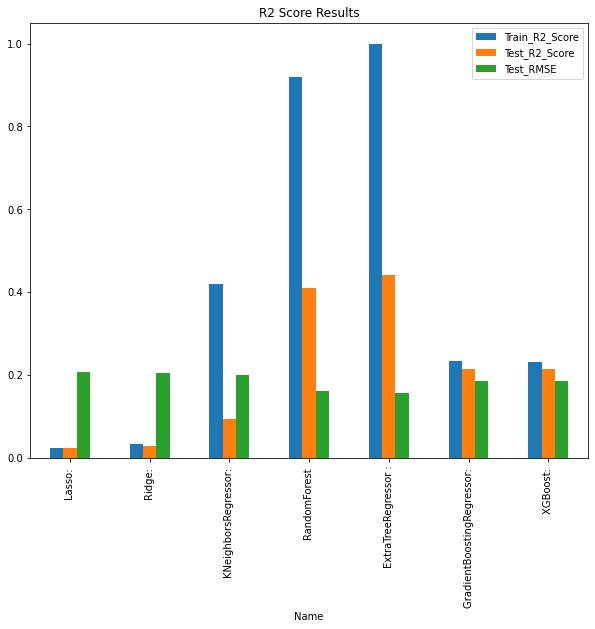

In [27]:
model_scores.plot(x="Name", y=['Train_R2_Score', 'Test_R2_Score', 'Test_RMSE'], kind="bar" , title = 'R2 Score Results' , figsize= (10,8)) ;

## Best model performance: ExtraTreesRegressor

In [28]:
regressor = ExtraTreesRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [29]:
print("Random Forest Regressor's Mean Absolute Error: " + str(mean_absolute_error(y_pred, y_test)))
y.describe()

Random Forest Regressor's Mean Absolute Error: 9.110010615711252


count    42390.000000
mean        19.192097
std         21.121689
min        -60.000000
25%         13.000000
50%         24.000000
75%         30.000000
max         60.000000
Name: estimated_delivery_time, dtype: float64

Prediction accuracy is 44% with a mean square error of 9 days. The model accuracy is at an acceptable level. There are several point to take note in order to improve the accuracy of the model

There are outliers in the data that can be removed (max delivery time is 60 days).

Distance is not a good representation of how hard it may take for an object to go from A to B. Transport infrastructure, availabilty of flights, metro, trains and developments in sellers' location can influence the time taken to deliver. We do not have these information.

Most of the time, we have a wide difference between actual and estimated delivery time from the datasets provided.
The records suggest that Company delivery system was inefficient and thus making any hopes to properly predicting the delivery time tedious.
The extreme randomness of the data's distribution makes it difficult to reach very high levels of accuracy.